In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk(' '):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from matplotlib import pyplot as plt

from tqdm import tqdm
from PIL import Image as Img
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input, Embedding, multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist


C:\Users\SM\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from PIL import Image
import os
import numpy as np
from tqdm import tqdm

img_DIR =  'C:/Users/SM/Desktop/Python Work/mll/img2'
img_count = 10000

org_width = 178
org_height = 208
diff = (org_height - org_width) // 2

width_act = 128
ht_act = 128

crop_rect = (0, diff, org_width, org_height - diff)

images = []

for pic_file in tqdm(os.listdir(img_DIR)[:img_count]):
    pic_path = os.path.join(img_DIR, pic_file)
    pic = Image.open(pic_path).crop(crop_rect)
    pic.thumbnail((width_act, ht_act), Image.ANTIALIAS)
    images.append(np.array(pic, dtype=np.uint8))


100%|███████████████████████████████████████████████████████████████████████████████| 109/109 [00:00<00:00, 720.02it/s]


In [4]:
images = np.array(images) / 255
print(images.shape)


(109, 128, 128, 3)


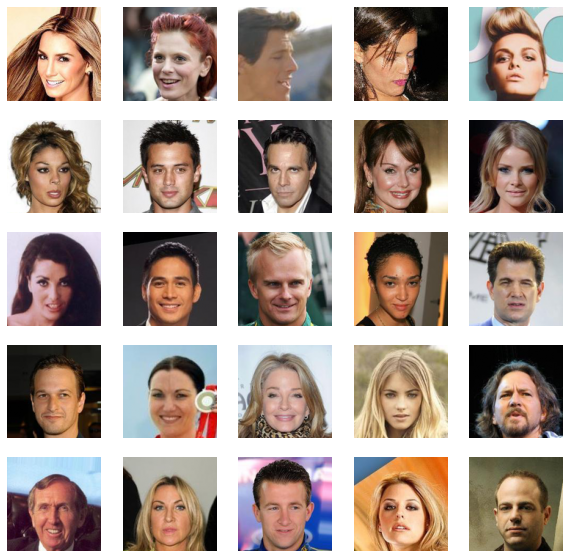

In [5]:
#Display first 25 images
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()


In [6]:
z_dim = 32
num_channel = 3

def create_generator():
    gen_input = Input(shape=(z_dim, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(num_channel, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator


In [8]:
def create_discriminator():
    disc_input = Input(shape=(ht_act, width_act, num_channel))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator


In [9]:
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot

generator = create_generator()
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 32768)             1081344   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      104883

In [10]:
discriminator = create_discriminator()
discriminator.trainable = False
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 126, 126, 256)     7168      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 126, 126, 256)     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 62, 62, 256)       1048832   
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 62, 62, 256)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 256)       1048832   
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 30, 30, 256)       0   

C:\Users\SM\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
gan_input = Input(shape=(z_dim, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

In [12]:
optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

In [13]:
gan.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32)]              0         
                                                                 
 model (Functional)          (None, 128, 128, 3)       14953987  
                                                                 
 model_1 (Functional)        (None, 1)                 4211713   
                                                                 
Total params: 19,165,700
Trainable params: 14,953,987
Non-trainable params: 4,211,713
_________________________________________________________________


In [17]:
import os

directory = 'mll'
if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Directory '{result_path}' created.")

gan.save_weights('mll/gan_weights.h5')


In [17]:
import time
iters = 100
size_of_batches = 5
images_saved = 0

result_path = 'finalres'
FILE_PATH = f'finalres/generated_{images_saved}.png'
if not os.path.isdir(result_path):
    os.mkdir(result_path)

size_taken = 6
control_vectors_used = np.random.normal(size=(size_taken**2, z_dim)) / 2

start = 0
d_losses = []
a_losses = []

for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(size_of_batches, z_dim))
    generated = generator.predict(latent_vectors)

    real = images[start:start + size_of_batches]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((size_of_batches, 1)), np.zeros((size_of_batches, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(size_of_batches, z_dim))
    misleading_targets = np.zeros((size_of_batches, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += size_of_batches
    if start > images.shape[0] - size_of_batches:
        start = 0

    if step % 50 == 49:
        gan.save_weights('mll/gan_weights.h5')

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_image = np.zeros((width_act * size_taken, ht_act * size_taken, num_channel))
        control_generated = generator.predict(control_vectors_used)
        
        for i in range(size_taken ** 2):
            x_off = i % size_taken
            y_off = i // size_taken
            control_image[x_off * width_act:(x_off + 1) * width_act, y_off * ht_act:(y_off + 1) * ht_act, :] = control_generated[i, :, :, :]
        im = Img.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH)
        images_saved += 1

1/1 [==============================] - 7s 7s/step
50/100: d_loss: 0.6092,  a_loss: 0.7952.  (34.5 sec)
1/1 [==============================] - 7s 7s/step
100/100: d_loss: 0.5731,  a_loss: 0.9400.  (35.0 sec)
2/2 [==============================] - 56s 6s/step


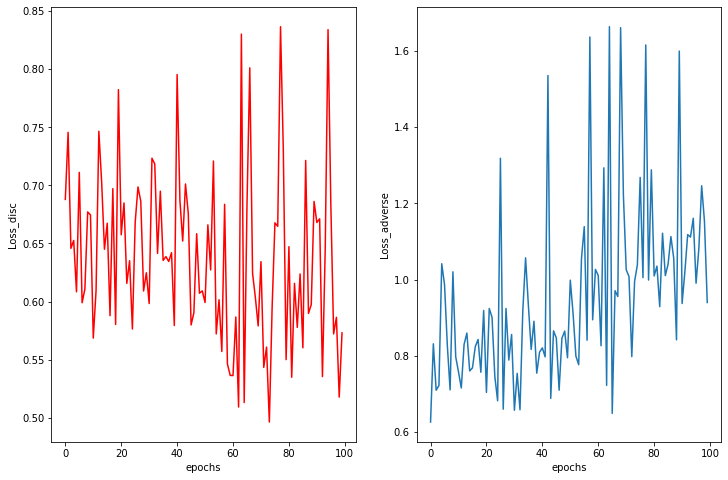

In [18]:
plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses, color='red')
plt.xlabel('epochs')
plt.ylabel('Loss_disc')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('Loss_adverse')
plt.show()

In [21]:
import imageio
import os
import shutil

RES_DIR = 'C:/Users/SM/Desktop/Python Work/mll/img2'  # Replace with the actual directory path

images_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(os.path.join(RES_DIR, filename)))

imageio.mimsave('training_visual1.gif', images_to_gif)
shutil.rmtree(RES_DIR)
